# Active learning using kili-technology

In this tutorial, we will see how you can use an active learning framework in conjunction with kili-technology to increase your productivity. 

It is no secret that machine learning models, especially deep learning models, need lots of training data. In the real world, unsupervised data is plenty while supervised data is rare and costly to obtain. Thus, you may be interested in using active learning : it is the task of choosing well the data samples to annotate to get the best performance given a fixed number of annotations.

At kili-technology, we develop the best annotation platform, to quickly get a production ready dataset. One of the features of our python - graphQL API is the ability to order the data samples to annotate, by giving them priority. This allows the use of active learning algorithms. We will show you how to do that here :

## Creating the project

In [5]:
# Authentication
import os

!pip install kili # uncomment if you don't have kili installed already
from kili.client import Kili

api_key = os.getenv('KILI_API_KEY')
api_endpoint = os.getenv('KILI_API_ENDPOINT')# If you use Kili SaaS use 'https://cloud.kili-technology.com/api/label/v2/graphql'

kili = Kili(api_key=api_key, api_endpoint=api_endpoint)

Let's set up a project. For this example, we will use the MNIST dataset and digit classification task.

In [8]:
# JSON interface
job_id = 'JOB_0'
json_interface = {
  "jobs": {
    job_id: {
      "mlTask": "CLASSIFICATION",
      "content": {
        "input": "radio",
        "categories": {
          "0": {
            "name": "0"
          },
          "1": {
            "name": "1"
          },
          "2": {
            "name": "2"
          },
          "3": {
            "name": "3"
          },
          "4": {
            "name": "4"
          },
          "5": {
            "name": "5"
          },
          "6": {
            "name": "6"
          },
          "7": {
            "name": "7"
          },
          "8": {
            "name": "8"
          },
          "9": {
            "name": "9"
          }
        }
      },
      "required": True,
      "instruction": "Classify following numbers"
    }
  }
}

In [9]:
# Create project
title = 'Active learning with Kili Technology'
description = 'This is a demo project'
input_type = 'IMAGE'

project = kili.create_project(
    description=description,
    input_type=input_type,
    json_interface=json_interface,
    title=title,
    user_id=kili.auth.user_id
)
project_id = project['id']

## Downloading and setting up the dataset

In [10]:
import os
import glob
import random
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset

In [11]:
np.random.seed(42)

In [ ]:
original_mnist = torchvision.datasets.MNIST(
    root='data/', train=True, transform=transforms.ToTensor(), download=True
)

I convert images of the dataset into the png format using this script

In [18]:
# cf !git clone https://github.com/myleott/mnist_png
import struct
import sys
from array import array
from os import path

# source: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
def read(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array("B", fimg.read())
    fimg.close()

    return lbl, img, size, rows, cols

def write_dataset(labels, data, size, rows, cols, output_dir):
    # create output directories
    output_dirs = [
        path.join(output_dir, str(i))
        for i in range(10)
    ]
    for dir in output_dirs:
        if not path.exists(dir):
            os.makedirs(dir)

    # write data
    for (i, label) in tqdm.tqdm(enumerate(labels), total=len(labels)):
        output_filename = path.join(output_dirs[label], str(i) + ".png")
        with open(output_filename, "wb") as h:
            w = png.Writer(cols, rows, greyscale=True)
            data_i = [
                data[ (i*rows*cols + j*cols) : (i*rows*cols + (j+1)*cols) ]
                for j in range(rows)
            ]
            w.write(h, data_i)
            
            
input_path = 'data/MNIST/raw/'
output_path = 'data/MNIST/png'

for dataset in ["training", "testing"]:
    labels, data, size, rows, cols = read(dataset, input_path)
    write_dataset(labels, data, size, rows, cols,
                  path.join(output_path, dataset))

60000it [00:44, 1357.56it/s]
10000it [00:07, 1372.92it/s]


We will use the 5000 first training samples as a validation dataset, and 10000 random samples as training data

In [19]:
validation_size = 5000
train_size = 10000

id_train = np.random.choice(np.arange(validation_size, len(original_mnist)), size=train_size, replace=False)
idtrain2range = {v: i for i, v in enumerate(id_train)}
range2idtrain = {i: v for i, v in enumerate(id_train)}

# Keep some examples as a validation
mnist_validation = TensorDataset(
    original_mnist.data[:validation_size].float() * 2.0 / 255.0 -1.0,
    original_mnist.targets[:validation_size]
)

In [ ]:
y_train = original_mnist.targets[id_train].numpy()
files2push = []
external_ids = []
for i, id_ in tqdm.notebook.tqdm(enumerate(id_train)):
    y_i = y_train[i]
    path_i = f'data/MNIST/png/training/{y_i}/{id_}.png'
    files2push.append(path_i)
    external_ids.append(id_)

Import images to kili-technology :

In [29]:
# kili.append_many_to_dataset(project_id=project_id,
#                                  content_array=files2push,
#                                  external_id_array=external_ids)

## AL in practice

In [30]:
# All examples that are not yet labelled have a label set to -1
def unlabeled_dataset():
    return TensorDataset(
        original_mnist.data[id_train].float() * 2.0 / 255.0 -1.0,
        torch.zeros_like(original_mnist.targets[id_train])-1
    )


def process_label(kili_label):
    """
    Transform the label produced by kili technology into the label suited for the task.
    """
    return int(kili_label[0]['jsonResponse']['JOB_0']['categories'][0]['name'])

assetId2priority = defaultdict(int)
def call_expert(dataset, indices, local=True):
    """
    This function labels the requested examples
    """
    if local:
        label_counter = defaultdict(int)
        for i in indices:
            y_i = original_mnist.targets[range2idtrain[int(i)]]
            dataset.tensors[1][i] = y_i
            label_counter[int(y_i)] += 1
        return label_counter
    else:
        assets = kili.assets(project_id=project_id, fields=['externalId', 'id'])
        extarnalId2asset = {}
        for asset in assets:
            extarnalId2asset[int(asset['externalId'].split('.')[0])] = asset
        # To maintain an ordered dataset, increase the priority of all previous labeled samples, in case
        # all queried assets are not yet labeled.
        # You can also make sure manually that the queried samples are labeled.
        for i in indices:
            assetId2priority[i] += 1
        for i in assetId2priority.keys():
            if i not in indices:
                assetId2priority[i] += 1
            try:
                kili.update_properties_in_asset(asset_id=extarnalId2asset[i]['id'],
                                                  priority=assetId2priority[i])
            except:
                raise ValueError(f'Did you upload asset with external id {i} into kili ?')
        # Label assets in the application
        done = input("Did you label the queried inputs ? ")
        if done:
            external_ids = [f'{i}.png' for i in indices]
            labeled_assets = kili.assets(project_id=project_id,
                                               external_id_contains=external_ids,
                                               fields=['priority', 'labels.jsonResponse', 'externalId'])
            external2labeled_assets = {}
            for asset in labeled_assets:
                external2labeled_assets[int(asset['externalId'].split('.')[0])] = asset
            for i in indices:
                if len(external2labeled_assets[i]['labels']) > 0:
                    dataset.tensors[1][idtrain2range[i]] = process_label(external2labeled_assets[i]['labels'])

# Keep 5000 examples as a validation
mnist_validation = TensorDataset(
    original_mnist.data[:5000].float() * 2.0 / 255.0 -1.0,
    original_mnist.targets[:5000]
)

In [33]:
# Uncomment the following lines to test the query mechanism  :

# dataset = unlabeled_dataset()
# print(f'Label asset with external id {id_train[0]}')
# call_expert(dataset, [id_train[0]], local=False)
# assets = kili.assets(project_id=project_id,
#                   fields=['priority', 'labels.jsonResponse', 'externalId'],
#                   external_id_contains=[f'{id_train[0]}.png'])
# asset = assets[0]
# label = process_label(asset['labels'])
# print('Asset : ', asset, 'label : ', label)

In [34]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv = nn.Sequential(*[
            nn.Conv2d(1, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*16, 10)
        ])
    
    def forward(self, x):
        if x.dim() != 4:
            x = x[:, None, :, :]
        return self.conv(x)

In [35]:
# number of training iterations between each expert call
# the number of epochs is thus num_iter * batch_size / len(dataset)
BATCH_SIZE = 32
CRITERION = nn.CrossEntropyLoss()
LEARNING_RATE = 0.003

In [36]:
def get_preds(model, dataset):
    loader = DataLoader(dataset, batch_size=512, shuffle=False)
    preds = []
    with torch.no_grad():
        for (data, _) in loader:
            data = data
            prediction = model(data)
            preds.append(prediction.data)
    return torch.cat(preds).numpy()

In [37]:
def random_strategy(model, dataset, n=100):
    # label 100 new examples at random
    N = len(dataset)
    return torch.tensor(np.random.choice(N, size=n, replace=False)), None
    # return torch.randint(0, N, (100,))

def uncertainty_sampling(model, dataset, n=100):
    """
    This strategy outputs the samples whose top predictions are the lowest
    """
    preds = get_preds(model, dataset)
    probas = np.exp(preds) / np.exp(preds).sum(axis=1)[:, None]
    top_pred = np.max(probas, axis=1)
    ids = np.argsort(top_pred)[:n]
    return torch.LongTensor(ids)
    
def margin_sampling(model, dataset, n=100):
    """
    This strategy outputs the samples whose difference between the top predicted class
    and the second most probable class is the lowest.
    This strategy is experimentally the BEST : the fastest to get good results, and with results
    that stay above other strategies.
    (90.7% acc with 200 samples, 96.2% acc with 700 samples).
    """
    preds = get_preds(model, dataset)
    probas = np.exp(preds) / np.exp(preds).sum(axis=1)[:, None]
    sorted_preds = np.argsort(probas, axis=1)
    top_preds = probas[np.arange(len(probas)), sorted_preds[:, -1]]
    second_preds = probas[np.arange(len(probas)), sorted_preds[:, -2]]
    diff = top_preds - second_preds
    ids = np.argsort(diff)[:n]
    return torch.LongTensor(ids), probas[ids]

def entropy_sampling(model, dataset, n=100):
    """
    This strategy outputs the samples whose entropy on the predicted class is the largest
    (maximum when all classes have equal probability, minimum when one class has probability 1)
    """
    preds = get_preds(model, dataset)
    probas = np.exp(preds) / np.exp(preds).sum(axis=1)[:, None]
    entropies = -np.sum(probas * np.log(probas), axis=1)
    ids = np.argsort(entropies)[-n:]
    return torch.LongTensor(ids)

def my_awesome_strategy(model, dataset, n=100):
    # implement your strategies as new functions here
    pass

In [42]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def train_model(model, optimizer, loader, epochs):
    for _ in range(epochs):
        for (data, targets) in loader:
            model.zero_grad()
            prediction = model(data)
            loss = CRITERION(prediction, targets)
            loss.backward()
            optimizer.step()
    
def validation_perf(model, dataset):
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    total_accuracy = 0.0
    total_loss = 0.0
    with torch.no_grad():
        for (data, targets) in loader:
            prediction = model(data)
            total_loss += CRITERION(prediction, targets).item() * data.size(0)
            _, number_predicted = torch.max(prediction.data, 1)
            total_accuracy += (number_predicted == targets).sum()
    return (total_accuracy / len(dataset), total_loss / len(dataset))

class Active_Learner:
    
    def __init__(self,
                 initial_labeling=20,
                 stop_labeling=20,
                 num_iter=200,
                 num_active_runs=20,
                 step_labeling=50,
                 n_repeats=5):
        self.initial_labeling = initial_labeling
        self.stop_labeling = stop_labeling
        self.num_train_iter = num_iter
        self.num_active_runs = num_active_runs
        self.step_labeling = step_labeling
        self.n_repeats = n_repeats
        self.dataset = None
        
    def _reset(self):
        self.dataset = unlabeled_dataset()
        to_annotate = np.random.choice(len(self.dataset), size=self.initial_labeling, replace=False)
        call_expert(self.dataset, torch.tensor(to_annotate))
              
    def train_on_labeled(self):
        # filter the dataset to only keep labelled examples
        labelled_idx = self.dataset.tensors[1] >= 0
        filtered_dataset = TensorDataset(*list(t[labelled_idx] for t in self.dataset.tensors))
        loader = DataLoader(filtered_dataset, batch_size=BATCH_SIZE, shuffle=True)
        # create a new model to train on this dataset
        model = ConvModel()
        # OPTIMIZER
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        train_model(model, optimizer, loader, self.num_train_iter // len(loader))
        return model, len(filtered_dataset)        
            
    def run_algorithm(self, strategy):
        all_performances = []
        labeled = []
        total = self.n_repeats * (self.num_active_runs+1)
        for a in range(self.n_repeats):
            self._reset()
            performances = torch.zeros(self.num_active_runs+1, 3)
            to_labels = []
            for i in range(self.num_active_runs+1):
                model, length_labeled = self.train_on_labeled()
                (valid_acc, valid_loss) = validation_perf(model, mnist_validation)
                performances[i, 0] = length_labeled
                performances[i, 1] = valid_acc
                performances[i, 2] = valid_loss
                # print("With {} examples, valid perf is: {:.3f} -- {:.2f}%".format(length_labeled, valid_loss, valid_acc*100))

                unlabelled_idx = self.dataset.tensors[1] < 0
                unlabelled_dataset = TensorDataset(*list(t[unlabelled_idx] for t in self.dataset.tensors))
                unlabelled2dataset = {}
                s = 0
                for r, v in enumerate(unlabelled_idx):
                    if v:
                        unlabelled2dataset[s] = r
                        s += 1
                print(f'{a*(self.num_active_runs+1)+i+1}/{total}')
                unlabeled2label, logs = strategy(model, unlabelled_dataset, self.step_labeling)
                if logs is not None:
                    pass
                to_label = [unlabelled2dataset[int(k)] for k in unlabeled2label]
                to_labels.extend(to_label)
                label_counter = call_expert(self.dataset, to_label)
                
                # print({k: v for k, v in sorted(label_counter.items(), key=lambda item: item[1])})
            all_performances.append(performances)
            labeled.append(to_labels)
        return torch.cat(all_performances), labeled

In [43]:
# a list of strategies you want to compare
strategies = [random_strategy, margin_sampling] # uncertainty_sampling, margin_sampling
# number of examples to label randomly at the start
initial_labeling = 100
step_labeling = 50
n_repeats = 5
num_active_runs = 10

AL = Active_Learner(initial_labeling=initial_labeling, step_labeling=step_labeling,
                    num_active_runs=num_active_runs, n_repeats=n_repeats)
performances = []
strat2labeled = {}
for strat in strategies:
    print("Training with strategy: {}".format(strat.__name__))
    perf, labeled = AL.run_algorithm(strat)
    performances.append((strat.__name__, perf))
    strat2labeled[strat.__name__] = labeled
print("done")

Training with strategy: random_strategy
1/55
2/55
3/55
4/55
5/55
6/55
7/55
8/55
9/55
10/55
11/55
12/55
13/55
14/55
15/55
16/55
17/55
18/55
19/55
20/55
21/55
22/55
23/55
24/55
25/55
26/55
27/55
28/55
29/55
30/55
31/55
32/55
33/55
34/55
35/55
36/55
37/55
38/55
39/55
40/55
41/55
42/55
43/55
44/55
45/55
46/55
47/55
48/55
49/55
50/55
51/55
52/55
53/55
54/55
55/55
Training with strategy: margin_sampling
1/55
2/55
3/55
4/55
5/55
6/55
7/55
8/55
9/55
10/55
11/55
12/55
13/55
14/55
15/55
16/55
17/55
18/55
19/55
20/55
21/55
22/55
23/55
24/55
25/55
26/55
27/55
28/55
29/55
30/55
31/55
32/55
33/55
34/55
35/55
36/55
37/55
38/55
39/55
40/55
41/55
42/55
43/55
44/55
45/55
46/55
47/55
48/55
49/55
50/55
51/55
52/55
53/55
54/55
55/55
done


In [44]:
performances = [(name, perf.detach().cpu().numpy()) for (name, perf) in performances]

## Visualization

In [45]:
def getFinalTopAcc(perf):
    nbLabels = perf[1][:, 0]
    acc = perf[1][:, 1]
    maxLabels = np.max(nbLabels)
    meanTopAcc = acc[nbLabels == maxLabels].mean()
    return meanTopAcc
meanTopAccRandom = getFinalTopAcc(performances[0])
meanTopAccMargin = getFinalTopAcc(performances[1])

With less than half the number of queried labels, the accuracy using active learning with margin sampling is on average as good, than when not choosing assets to label :  performance is increased !

Text(0, 0.5, 'Accuracy')

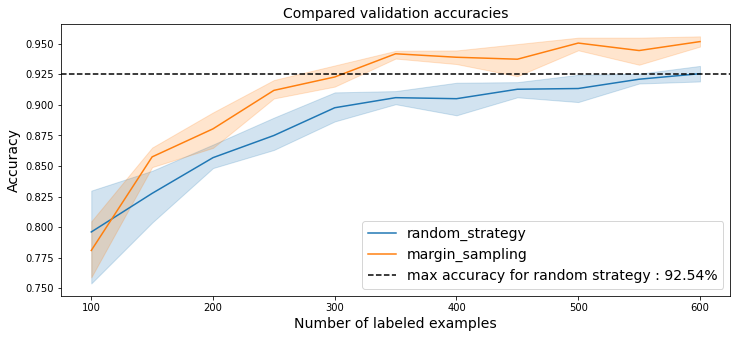

In [46]:
plt.figure(figsize=(12, 5))
for (name, perf) in performances:
    sns.lineplot(perf[:,0], perf[:,1], label=name)
plt.axhline(y=meanTopAccRandom, label=f'max accuracy for random strategy : {meanTopAccRandom:.2%}', linestyle='--', color='black')
plt.legend(loc='lower right', fontsize=14)
plt.title("Compared validation accuracies", fontsize=14)
plt.xlabel("Number of labeled examples", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

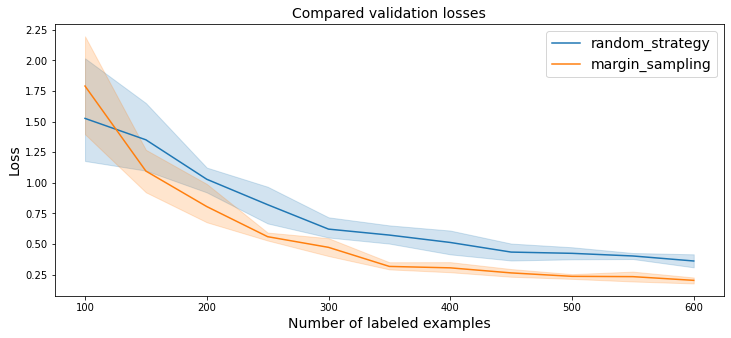

In [47]:
plt.figure(figsize=(12, 5))
plt.title("Compared validation losses", fontsize=14)
plt.xlabel("Number of labeled examples", fontsize=14)
plt.ylabel("Loss", fontsize=14)
for (name, perf) in performances:
    sns.lineplot(perf[:,0], perf[:,2], label=name)
plt.legend(loc='upper right', fontsize=14)
plt.show()

Queried samples are hard and informative, compared to randomly sampled numbers.

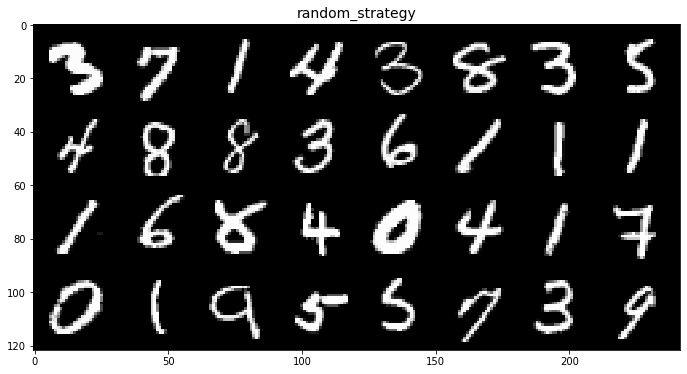

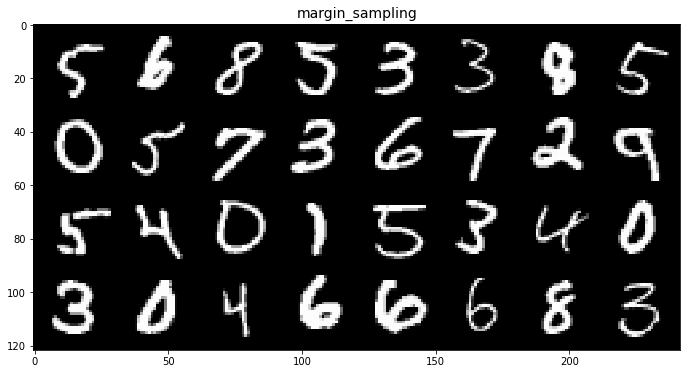

In [48]:
for strat, labeled in strat2labeled.items():
    plt.figure(figsize=(20, 6))
    show(torchvision.utils.make_grid(original_mnist.data[labeled[0][:32]].unsqueeze(1)))
    plt.title(strat, fontsize=14)

In [49]:
assert meanTopAccRandom < meanTopAccMargin